IMPORTAZIONE LIBRERIE

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import array 
import scipy.signal as signal
#Processing libraries
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns
from scipy.stats import zscore
from sklearn.multiclass import OneVsRestClassifier

# Model libraries
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Testing libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_curve, auc

# remove warnings
import warnings
warnings.filterwarnings('ignore')

CAMBIO PATH PER ANALISI RISPETTO AL LOG DI VOLO CONSIDERAT

In [2]:
path_file = os.path.abspath(os.getcwd())
print(path_file)
os.chdir(path_file)

c:\Users\chiar\OneDrive\Desktop\MantenzionePreventiva\ProgettoManutenzionePreventiva


ARRAY CHE CONTERRA' I DATAFRAME DI CIASCUN VOLO (PER UN TOTALE DI 18)

In [3]:
data_path = os.path.join(path_file,'*.csv') #lista di tutti gli elementi di estensione csv nella cartella path
csv_list = glob.glob(data_path) #converte data path in un output Unix-like (ls) (*.csv -> lista di elementi con estensione csv)
dataframe_collection = []
df_1 = pd.DataFrame()

# ciclo per scorrere tutti i csv
for csv_file in csv_list: # ciclo che scorre i csv nella cartella path
    df = pd.read_csv(csv_file) 
    #df = df.to_numpy()
    #df = df.to_records(index=False)
    #dataframe_collection.append(df)
    df_1 = df_1.append(df,ignore_index=True)
    #print(df)


In [4]:
#df_1.to_csv('totale.csv', index=False)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#display(df_1)

In [ ]:
df_1 = df_1.sample(frac=1).reset_index(drop=True)
print(df_1)

In [5]:
df_1 = df_1.drop(['tempo'], axis=1)
print(df_1)

      <>(GyrX)  var(GyrX)  kurt(GyrX)  RMS(GyrX)  freq1(GyrX)  freq2(GyrX)  \
0    -0.032100   0.017081   -0.399284   0.134398         78.0         96.0   
1    -0.032346   0.017054   -0.400010   0.134356        102.0         80.0   
2    -0.032590   0.017026   -0.400594   0.134314         98.0         79.0   
3    -0.032832   0.016999   -0.401113   0.134271        102.0         71.0   
4    -0.033265   0.017017   -0.412325   0.134447        102.0         87.0   
5    -0.033648   0.017022   -0.420697   0.134558        102.0         81.0   
6    -0.033887   0.016994   -0.421044   0.134518        102.0         80.0   
7    -0.034101   0.016963   -0.420144   0.134457        108.0         89.0   
8    -0.034521   0.016979   -0.430436   0.134623        100.0         73.0   
9    -0.034876   0.016977   -0.437115   0.134708        102.0         86.0   
10   -0.034905   0.016930   -0.430255   0.134542        106.0         83.0   
11   -0.034856   0.016884   -0.423007   0.134359        106.0   

### Bilanciamento del dataset

In [7]:
#separazione da tollerabile a non_tollerabile
no_guasto = df_1[df_1['Guasto'] == 0]
guasto_5 = df_1[df_1['Guasto'] == 1]
guasto_10 = df_1[df_1['Guasto'] == 2]

print("No Guasto: ", len(no_guasto), "Guasto 5%: ", len(guasto_5), "Guasto 10%: ", len(guasto_10))

No Guasto:  390 Guasto 5%:  418 Guasto 10%:  541


In [8]:
#bilanciamento del dataset
balanced_d = pd.concat([no_guasto, guasto_5.sample(len(no_guasto)), guasto_10.sample(len(no_guasto))])
#balanced_d = pd.concat([tollerabile, non_tollerabile.sample(len(tollerabile))])
x = balanced_d.iloc[:,:-1]
y = balanced_d.iloc[:,-1:]
balanced_d.shape

(1170, 169)

In [ ]:
'''x = df_1.iloc[:,:-1]
y = df_1.iloc[:,-1:]'''

In [ ]:
'''oversample = SMOTE()
x, y = oversample.fit_resample(x,y)
print(x)'''

# Selezione feature più importanti

In [9]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, f_regression
fvalue_Best = SelectKBest(score_func=f_regression, k=20)
fit = fvalue_Best.fit(x, y)
print(fit)
print(fvalue_Best.get_support())

SelectKBest(k=20, score_func=<function f_regression at 0x00000251359A9900>)
[False False False False False False False False  True  True False  True
  True False  True False False False False False False False  True False
 False False False False  True False  True False  True False  True False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False  True  True False False
 False False False False False False False False  True False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False

In [ ]:
features_score = pd.DataFrame(fit.scores_)
features_score = zscore(features_score)
features = pd.DataFrame(x.columns)
feature_score = pd.concat([features,features_score],axis=1)
# Assigning column names
feature_score.columns = ["Input_Features","F_Score"]
print(feature_score.nlargest(60,columns="F_Score"))

In [10]:
i=0
index_false=[]
for el in list(fvalue_Best.get_support()):
    if not el:
        index_false.append(i)
    i=i+1
print(index_false)

[0, 1, 2, 3, 4, 5, 6, 7, 10, 13, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 29, 31, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167]


In [11]:
x=x.drop(x.columns[index_false],axis = 1)
print(x)

      <>(GyrY)  var(GyrY)  RMS(GyrY)  freq1(GyrY)  amp1(GyrY)  amp1(GyrZ)  \
192   0.579080   0.002838   0.013588     0.469697    0.024704    0.073784   
193   0.577916   0.002771   0.013192     0.484848    0.033723    0.067646   
194   0.577117   0.002614   0.012684     0.454545    0.037330    0.044502   
195   0.576296   0.002462   0.012184     0.477273    0.036807    0.038841   
196   0.574831   0.002503   0.011954     0.424242    0.028038    0.062047   
197   0.573514   0.002491   0.011648     0.515152    0.031945    0.074135   
198   0.572778   0.002325   0.011140     0.446970    0.034271    0.040409   
199   0.571495   0.002305   0.010826     0.522727    0.038063    0.071344   
200   0.569987   0.002369   0.010646     0.492424    0.032734    0.078465   
201   0.569649   0.002150   0.010110     0.431818    0.027233    0.062402   
202   0.567862   0.002338   0.010141     0.553030    0.034143    0.033646   
203   0.565261   0.003001   0.011023     0.431818    0.036884    0.051834   

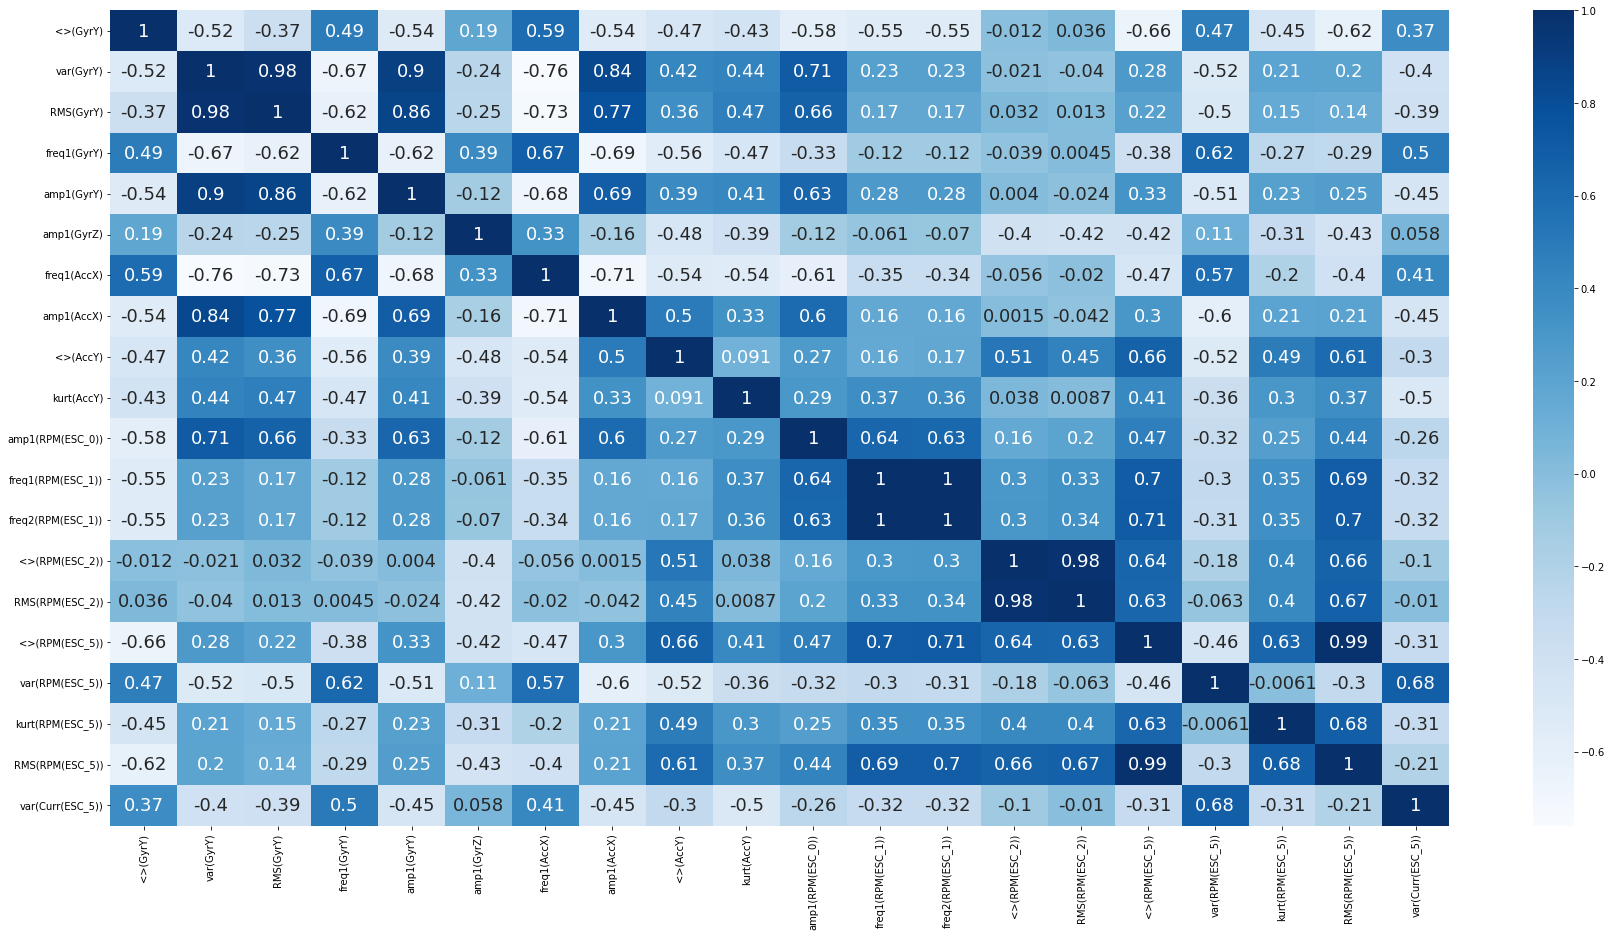

In [12]:
plt.figure(figsize=(30,15))
ax = sns.heatmap(x[x.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [13]:
x = x.drop(['var(GyrY)','freq1(RPM(ESC_1))','<>(RPM(ESC_5))','RMS(RPM(ESC_2))'], axis=1)

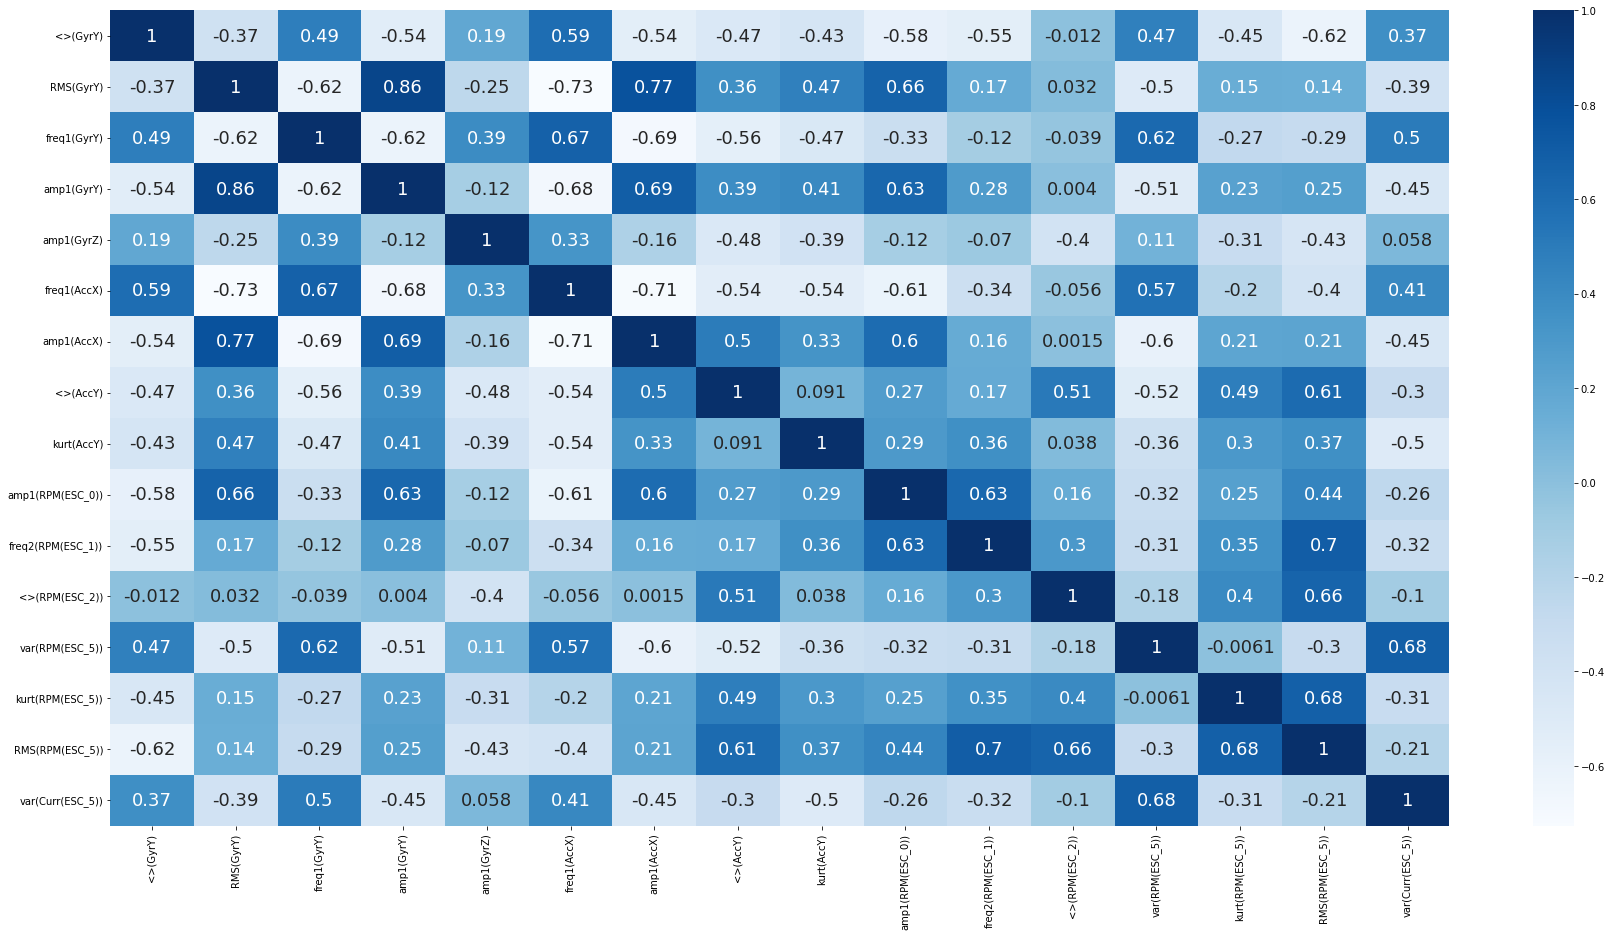

In [14]:
plt.figure(figsize=(30,15))
ax = sns.heatmap(x[x.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

### Separazione del dataset in training e test

In [15]:
# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(936, 16)
(234, 16)
(936, 1)
(234, 1)


In [16]:
from sklearn.calibration import CalibratedClassifierCV

# List of classifiers:
classifiers = [
    LogisticRegression(random_state = rs),
    DecisionTreeClassifier(random_state=rs, criterion="entropy"),
    RandomForestClassifier(n_estimators = 10, random_state=rs),
    GradientBoostingClassifier(random_state= rs),
    AdaBoostClassifier(n_estimators=10, random_state= rs),
    LinearDiscriminantAnalysis(),
    SVC(probability=True),
    MLPClassifier(random_state=rs), # Multi Layer Perceptron
    SGDClassifier(random_state=rs) # Stochastic Gradient Descent 
]

# List of results that will occure:
clf_name = [] # names of the classifiers
model_results = pd.DataFrame.copy(y_test) #resulting of prediction from the models

kfold = StratifiedKFold(n_splits=5) #cross-validation
cv_results = [] # scores from cross validation
cv_acc = [] # mean accuracy from cross validation, need to maximize
cv_std = [] # standard deviation from cross validation, need to minimise

cnfm = [] #confusion matrix
clr = [] #classification report
roc_auc = [] #roc curve:
roc_tpr = []
roc_fpr = []

### Classificazione

Cross-Validation: [0.99468085 0.98930481 1.         1.         0.98395722]
Accuracy: 1.0 	 ---> LogisticRegression 


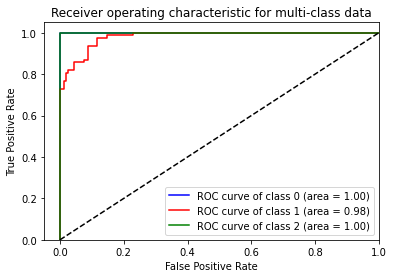

----------------------------------------------------
Cross-Validation: [1.         1.         1.         0.98930481 1.        ]
Accuracy: 1.0 	 ---> DecisionTreeClassifier 


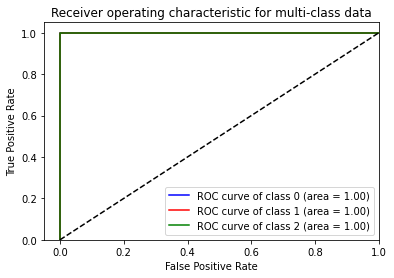

----------------------------------------------------
Cross-Validation: [1. 1. 1. 1. 1.]
Accuracy: 1.0 	 ---> RandomForestClassifier 


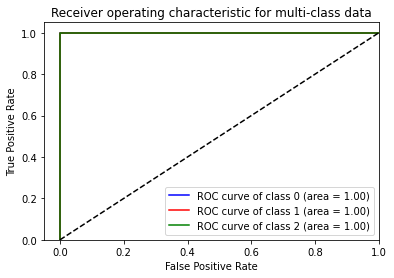

----------------------------------------------------
Cross-Validation: [1.         1.         1.         0.98930481 1.        ]
Accuracy: 1.0 	 ---> GradientBoostingClassifier 


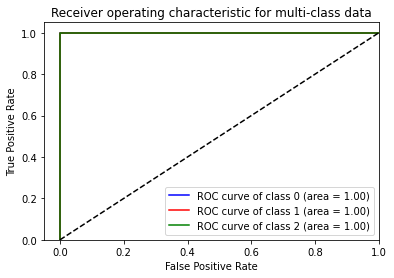

----------------------------------------------------
Cross-Validation: [1.         0.99465241 1.         0.99465241 0.96256684]
Accuracy: 0.91 	 ---> AdaBoostClassifier 


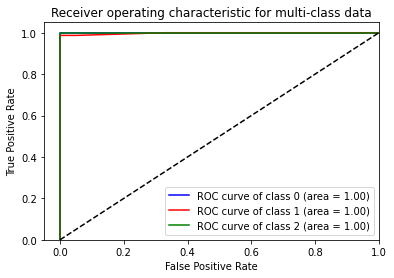

----------------------------------------------------
Cross-Validation: [1.         0.99465241 1.         1.         1.        ]
Accuracy: 1.0 	 ---> LinearDiscriminantAnalysis 


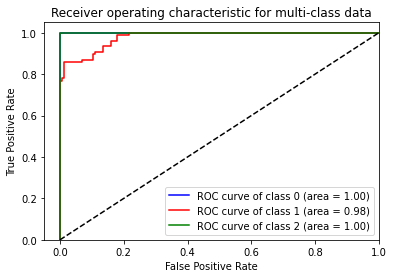

----------------------------------------------------
Cross-Validation: [1. 1. 1. 1. 1.]
Accuracy: 1.0 	 ---> SVC 


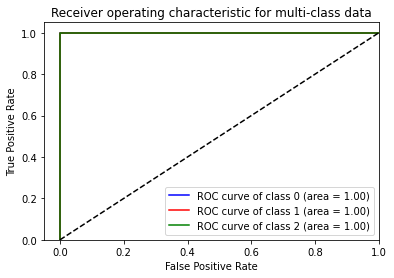

----------------------------------------------------
Cross-Validation: [1. 1. 1. 1. 1.]
Accuracy: 1.0 	 ---> MLPClassifier 


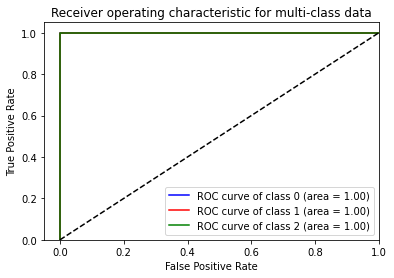

----------------------------------------------------
Cross-Validation: [0.99468085 0.98930481 0.97326203 1.         0.97326203]
Accuracy: 1.0 	 ---> SGDClassifier 


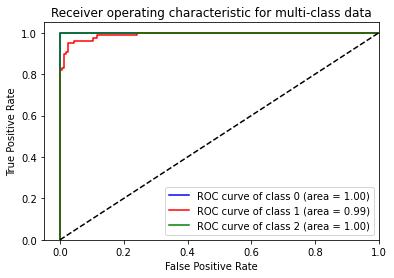

----------------------------------------------------


In [17]:
from itertools import cycle
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

n_classes = 3

j=0
# Training the algorithms and results
for clf in classifiers:
    name = clf.__class__.__name__
    clf_name.append(name)
    
    
    #fitting and predictions
    model = clf.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    model_results[name] = y_pred
    
    #accuracy and log loss
    cv_results.append(cross_val_score(clf, x_train, y_train.values.ravel(), scoring = "accuracy",cv = kfold)) # qui invece abbiamo cross validation
    acc = round(accuracy_score(y_test.values.ravel(), y_pred), 2) # accuratezza semplice con training e test
    train_pred = clf.predict(x_test)
    print(f'Cross-Validation: {cross_val_score(clf, x_train, y_train.values.ravel(), scoring = "accuracy",cv = kfold)}') 
    
    print(f'Accuracy: {acc} \t ---> {name} ')

    '''guasto_pred = pd.Series(model.predict(df_test), name='Guasto_test')
    conteggio = guasto_pred.value_counts()
    print(f'Test: {conteggio}')'''    
    
    #confusion matrix, clasification report, roc curve
    cnfm.append(confusion_matrix(y_test.values.ravel(), y_pred))
    clr.append(classification_report(y_test.values.ravel(), y_pred))
    #fpr, tpr, thresholds = roc_curve(y_pred, y_test.values.ravel(), pos_label=1)

    if (j == 1) | (j == 2) |(j == 7):
        y_score = clf.fit(x_train, y_train).predict_proba(x_test)
    else:
        clf = OneVsRestClassifier(clf)
        y_score = clf.fit(x_train, y_train).decision_function(x_test)

       

    lb = LabelBinarizer()
    y_true_bin = lb.fit_transform(y_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=1.5)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class data')
    plt.legend(loc="lower right")
    plt.show()
    
    j += 1

    print("----------------------------------------------------")

for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())


### Matrici di confusione

In [ ]:
import seaborn as sns
# Confusion matrixes (not-normalized confusion matrix)
plt.figure(figsize=(20,15))
sns.set(font_scale=1.4)
for i in range(len(classifiers)):
    plt.subplot(3,3,i+1) #adjust this acourding to the number of algorithms
    sns.heatmap(cnfm[i], annot=True, fmt="d",cmap="Reds")
    plt.subplots_adjust(hspace = 0.5)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])

Cross Validation Scores

In [ ]:
# Cross validation accuracy results graph
cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})

plt.figure(figsize=(12,6))
sns.barplot(x="CrossValMeans",y="Algorithm",data = cv_res, palette="Set2",orient = "h",**{'xerr':cv_std})
plt.xlabel("Mean Accuracy")
plt.title("Cross validation scores")

Report Classificazione

In [ ]:
#Classification reports
for i in range(len(classifiers)):
    print (f"{clf_name[i]} Classification Report:" )
    print (clr[i])